# Practical Example

## High dimension

The practical example consists of the stable space estimation for a multivariate time series that contains the information of 205 economic indicators since January 2017 

In [ ]:
# packages
remove(list = ls())
options(warn = -1)
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(ggplot2))
suppressMessages(library(xtable))

source("../source/simulations.R")
source("../source/vectorial_methods.R")
source("../source/auxiliar_methods.R")

## Several econonomic indicators in Mexico

In [13]:
# Variables BIE
dt_BIE <- data.table::fread("../databases/variables_BIE.csv")
catalogue_BIE <- data.table::fread("../databases/catalogue_BIE.csv")

We centered the columns of the series, and we get the auxiliary blocks for the methods

In [14]:
X_BIE <- as.matrix(dt_BIE, rownames = "Date")
rownames(X_BIE) <- NULL
X_BIE <- scale(ts(X_BIE))
XX_BIE <- X_BIE[1:(nrow(X_BIE)-1),]
Y_BIE <- X_BIE[2:nrow(X_BIE),]

We check the order of integration of each variable. We count the number of series between the $m$ series that are $\textsf{I}(0)$, $\textsf{I}(1)$ and $\textsf{I}(2)$

In [15]:
aux <- X_BIE

# Step 1: Collect p-values for level, first difference, second difference
pvals_level <- apply(aux, 2, function(x) tryCatch(tseries::kpss.test(x)$p.value, error = function(e) NA))
pvals_diff1 <- apply(aux, 2, function(x) tryCatch(tseries::kpss.test(diff(x))$p.value, error = function(e) NA))
pvals_diff2 <- apply(aux, 2, function(x) tryCatch(tseries::kpss.test(diff(diff(x)))$p.value, error = function(e) NA))

# Step 2: Classify integration order
I0 <- which(pvals_level  > 0.05)
I1 <- which(pvals_level <= 0.05 & pvals_diff1 > 0.05)
I2 <- which(pvals_level <= 0.05 & pvals_diff1 <= 0.05 & pvals_diff2 > 0.05)

# Step 3: Report counts
cat("Number of I(0) series:", length(I0), "\n")
cat("Number of I(1) series:", length(I1), "\n")
cat("Number of I(2) series:", length(I2), "\n")


Number of I(0) series: 185 
Number of I(1) series: 19 
Number of I(2) series: 1 


We estimate the stable space for this multivariate time series using the methods
- PCA
- PLS

In [16]:
basis_BIE_PLS <- basis_stable(X_BIE, method = "pls")
basis_BIE_PCA <- basis_stable(XX_BIE,method="pca")

We check the estimated stable space dimension

In [17]:
cat("The PLS estimated dimension is: ", ncol(basis_BIE_PLS$basis_S))
cat("\nThe PCA estimated dimension is: ", ncol(basis_BIE_PCA$basis_S))

The PLS estimated dimension is:  191


The PCA estimated dimension is:  199

## Projection Error

We calculate the proyection onto the first two stable components. We also consider the first two principal components.

In [18]:
# PLS
T_scores_PLS <- basis_BIE_PLS$stable_scores 
Y_est_PLS <- scores_rebuilt(T_scores_PLS[,1:2],Y=Y_BIE,method = "PLS")

# PCA
T_scores_PCA <- XX_BIE%*%basis_BIE_PCA$basis_S
Y_est_PCA <- scores_rebuilt(T_scores_PCA[,1:2],Y=Y_BIE)

# PCA with the first two non-stable components
T_scores_PCA_non_stable <- XX_BIE%*%basis_BIE_PCA$basis_N[,1:2]
Y_est_PCA_non_stable <- scores_rebuilt(T_scores_PCA_non_stable[,1:2],Y=Y_BIE)

# PLS with the first two non-stable components
T_scores_PLS_non_stable <- XX_BIE%*%basis_BIE_PLS$basis_N[,1:2]
Y_est_PLS_non_stable <- scores_rebuilt(T_scores_PLS_non_stable[,1:2],Y=Y_BIE)

We could calculate the normalized MSE for each serie

In [19]:
MSE <- matrix(0,ncol(Y_BIE),4) 
colnames(MSE) <- c("non-stable PCA","stationary PCA","non-stable PLS","stationary PLS") ; rownames(MSE) <- colnames(Y_BIE)

# error estimation
MSE[,"stationary PLS"] <- VNMSE_(Y_BIE,Y_est_PLS$est)
MSE[,"stationary PCA"] <- VNMSE_(Y_BIE,Y_est_PCA$est)
MSE[,"non-stable PCA"] <- VNMSE_(Y_BIE,Y_est_PCA_non_stable$est)
MSE[,"non-stable PLS"] <- VNMSE_(Y_BIE,Y_est_PLS_non_stable$est)

Print the results of the estimation using the first two non-stable components and the first two stable components.

In [20]:
print(xtable(MSE[c("s23",head(names(I1),3),names(I2)),],digits = 2))

% latex table generated in R 4.1.2 by xtable 1.8-4 package
% Tue Jun 24 22:25:58 2025
\begin{table}[ht]
\centering
\begin{tabular}{rrrrr}
  \hline
 & non-stable PCA & stationary PCA & non-stable PLS & stationary PLS \\ 
  \hline
s23 & 0.99 & 0.26 & 0.98 & 0.25 \\ 
  imaief\_Hgo & 0.98 & 0.43 & 0.98 & 0.42 \\ 
  imaief\_SLP & 0.98 & 0.51 & 0.98 & 0.51 \\ 
  s54 & 0.99 & 0.42 & 0.99 & 0.43 \\ 
  rem\_cmenor & 0.98 & 0.17 & 0.99 & 0.17 \\ 
   \hline
\end{tabular}
\end{table}


We choose two series $\textsf{I}(1)$ for visualisation

In [21]:
options(repr.plot.width = 9, repr.plot.height = 6)

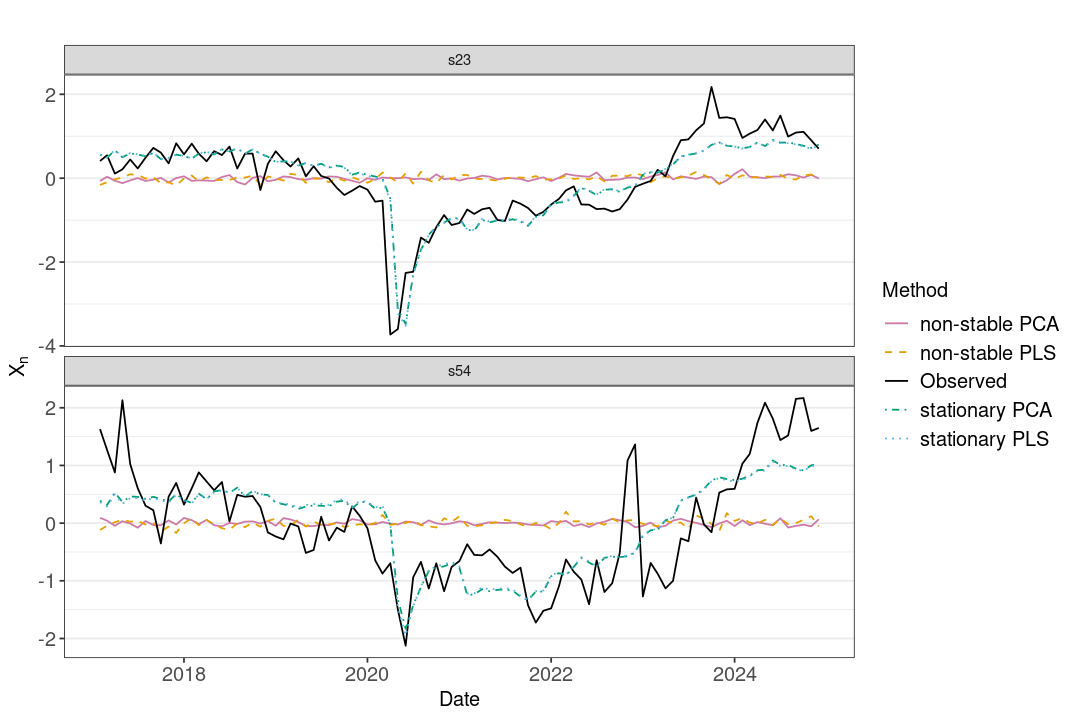

In [22]:
dates <- dt_BIE[,Date][2:nrow(dt_BIE)]

custom_linetypes <- c(
  "Observed" = "solid",
  "non-stable PCA" = "solid",
  "non-stable PLS" = "dashed",
  "stationary PCA" = "dotdash",
  "stationary PLS" = "dotted")

custom_palette <- c(
  "non-stable PLS" = "#E69F00",
  "stationary PLS" = "#56B4E9", 
  "stationary PCA" = "#009E73",
  "Observed" = "black",
  "non-stable PCA" = "#CC79A7")

plot_estimates_comparison(
  Y_obs = Y_BIE,
  Y_est_list = list(`stationary PLS` = Y_est_PLS$est, `stationary PCA` = Y_est_PCA$est, `non-stable PCA` = Y_est_PCA_non_stable$est,
  `non-stable PLS` = Y_est_PLS_non_stable$est),
  col_names = c("s23","s54"),
  labels = c("stationary PLS", "stationary PCA","non-stable PCA", "non-stable PLS"),  # optional if list has names
  dates = dates,
  method_palette = custom_palette,
  method_linetypes = custom_linetypes
)